# CamemBERT

CamemBERT is a state-of-the-art language model for French based on the RoBERTa architecture pretrained on the French subcorpus of the newly available multilingual corpus OSCAR.

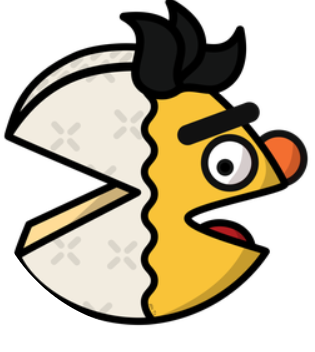

CamemBERT was pre-trained on a French corpus and with different hyper-parameters discovered and tested for the first time by the Facebook team. The choice of these hyper-parameters was so successful that the company announced the release of a "new" model called RoBERTa. However, there is nothing new in RoBERTA which, like CamemBERT, remains a copy of BERT. Here are these hyper-parameters:

CamemBERT chooses the words to be predicted dynamically, i.e., not during pre-processing of input data, but during forward pass, by randomly hiding some words of a sequence.
It uses a different batch size: ~8 000 against 256 in the case of BERT.
CamemBERT has only one pre-training goal: prediction of "hidden words" of a sequence. BERT had two: prediction of "hidden words" and of the next sentence of a sequence. This last objective proved to be unproductive for training.


## Environment Setup

In [ ]:
#!pip install transformers datasets seqeval

## Imports

In [4]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from torch.utils.data import DataLoader, SubsetRandomSampler
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoConfig,
    DataCollatorForTokenClassification,
    get_scheduler
)

## Part 1 : Data Processing


In [5]:
import pandas as pd
#train dataset
train=pd.read_csv('/content/train.csv')
# val & test datasets
val=pd.read_csv('/content/val.csv')
test=pd.read_csv('/content/test.csv')

In [6]:
frames = [train, val, test]
data = pd.concat(frames, ignore_index=True, sort=False)

In [7]:
data

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I802
1,Hémiplégie post-traumatique,S099
2,Masculinisation avec hyperplasie surrénale,E250
3,Hyperammoniémie cérébrale,E722
4,Fistule artérioveineuse congénitale périphériq...,Q257
...,...,...
241758,Syndrome OFC,Q870
241759,Sténose charnière recto-sigmoïdienne,K566
241760,Fracas fémur gauche,S729
241761,"Anémie normocytaire voir aussi Aplasie, médull...",D619


In [8]:
ner_tags = [['B-'+data['ICD10'][i]]+['I-'+data['ICD10'][i]]*(len(data['RawText'][i].split())-1) for i in range(data.shape[0])]

In [9]:
data['ner_tags']=ner_tags
data.head()

,RawText,ICD10,ner_tags
0,Thrombose veineuse profonde cuisse gauche,I802,"[B-I802, I-I802, I-I802, I-I802, I-I802]"
1,Hémiplégie post-traumatique,S099,"[B-S099, I-S099]"
2,Masculinisation avec hyperplasie surrénale,E250,"[B-E250, I-E250, I-E250, I-E250]"
3,Hyperammoniémie cérébrale,E722,"[B-E722, I-E722]"
4,Fistule artérioveineuse congénitale périphériq...,Q257,"[B-Q257, I-Q257, I-Q257, I-Q257, I-Q257, I-Q257]"


In [10]:
u = data.RawText.str.split(expand=True).stack()       
data_ner=pd.DataFrame({
    'Sentence': u.index.get_level_values(0) + 1, 
    'tokens': u.values, 
})
data_ner.head(6)

,Sentence,tokens
0,1,Thrombose
1,1,veineuse
2,1,profonde
3,1,cuisse
4,1,gauche
5,2,Hémiplégie


In [11]:
data_ner['ner_tag']=[tag for tag_list in data.ner_tags.tolist() for tag in tag_list]
data_ner.head(10)

,Sentence,tokens,ner_tag
0,1,Thrombose,B-I802
1,1,veineuse,I-I802
2,1,profonde,I-I802
3,1,cuisse,I-I802
4,1,gauche,I-I802
5,2,Hémiplégie,B-S099
6,2,post-traumatique,I-S099
7,3,Masculinisation,B-E250
8,3,avec,I-E250
9,3,hyperplasie,I-E250


In [12]:
data_ner.to_csv('dataset.csv')

In [13]:
import os
GS_DATA_DIR = "/content/"
DATA_DIR = "data"

FILEPATH = os.path.join(GS_DATA_DIR, "dataset.csv")

OUTPUT_FILEPATHS = [
  os.path.join(DATA_DIR, "train.jsonl"),
  os.path.join(DATA_DIR, "valid.jsonl"),
  os.path.join(DATA_DIR, "test.jsonl")
]

In [14]:
def write_output(tokens, labels, output_files, num_writter):
  assert(len(tokens) == len(labels))
  rec = json.dumps({ "tokens": tokens, "tags": labels })
  dice = random.random()
  if dice <= 0.75:
    output_files[0].write("{:s}\n".format(rec))
    num_written[0] += 1
  elif dice <= 0.85:
    output_files[1].write("{:s}\n".format(rec))
    num_written[1] += 1
  else:
    output_files[2].write("{:s}\n".format(rec))
    num_written[2] += 1


os.makedirs(DATA_DIR, exist_ok=True)
output_files = [open(filepath, "w") for filepath in OUTPUT_FILEPATHS]
num_written = [0, 0, 0]
tokens, labels = [], []
with open(FILEPATH, "r", encoding="latin-1") as fner:
  csv_reader = csv.reader(fner)
  next(csv_reader)  # skip header
  s=2
  for row in csv_reader:
    if row[0]==str(s) and len(tokens) > 0:
      # write out current sentence to train / valid / test
      write_output(tokens, labels, output_files, num_written)
      tokens, labels = [], []
      s=s+1
    # accumulate tokens and labels
    tokens.append(row[-2])
    labels.append(row[-1])
    # if num_written[0] > 1000:
    #   break

if len(tokens) > 0:
  write_output(tokens, labels, output_files, num_written)

[output_file.close() for output_file in output_files]
print(num_written)

[658278, 87637, 131553]


## Dataset

We now want to convert our three JSON-L files `train.jsonl`, `validation.jsonl` and `test.jsonl` files into our raw dataset.

First we produce a mapping of name to file path, and call `load_dataset` on it with `format="json"`.

This creates a DatasetDict object with three Datasets identified by the names specified in the `data_files` mapping.

In [15]:
data_files = {
    "train": OUTPUT_FILEPATHS[0],
    "validation": OUTPUT_FILEPATHS[1],
    "test": OUTPUT_FILEPATHS[2]
}
dataset = load_dataset("json", data_files=data_files)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-32d0af11d877bdf0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 658278
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 87637
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 131553
    })
})

In [16]:
# dataset["train"][0]

## Tokenization and Label Alignment

We now have to deal with the subword tokenization alignment problem that come with using Transformers.

Transformers use subword tokenization to split long words into their more common subwords, for example "Washington" could become "Wash", "##ing", and "##ton". Common subwords would be reused across different words. This helps to keep the vocabulary size down, or conversely, helps to cover a larger input vocabulary using the same size of tokenizer vocabulary.

However, our input sequence of `tokens` is space separated (with some additional heuristics around punctuation that is already taken care of in the provided input) and our `ner_tags` are aligned with this space-separated token sequence.

Since Transformers expect their input to be subword tokenized, the corresponding labels need to be aligned with the subword tokens as well. So for our "Washington" example, the corresponding labels will change from a single "B-LOC" to "B-LOC", "IGN", and "IGN", i.e. the trailing subwords would be ignored.

To do the mapping, we need the Tokenizer's `word_ids()` function, that maps the original token ids onto the subword tokenized sequence, which is only available from the "faster" Rust-based Tokenizer implementations. Fortunately, the AutoTokenizer will choose version of the Tokenizer for us automatically. We will use this to construct an "aligned" version of the `ner_tags`.


In [18]:
from datasets import load_dataset, load_metric
from transformers import CamembertTokenizerFast, CamembertForTokenClassification
tokenizer =  CamembertTokenizerFast.from_pretrained("camembert-base")

In [19]:
tokens = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True).tokens()
tokens

['<s>', '▁Thr', 'omb', 'ose', '▁veine', 'use', '</s>']

In [20]:
input = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True)
word_ids = input.word_ids()
pd.DataFrame([tokens, word_ids], index=["tokens", "word_ids"])

,0,1,2,3,4,5,6
tokens,<s>,▁Thr,omb,ose,▁veine,use,</s>
word_ids,None,0,0,0,1,1,None


### Class Label Mappings

In the encoded dataset, since the input will be converted to arrays of floats, we also want to do the same thing with the labels.

For this we construct a ClassLabel object and use its `int2str` and `str2int` methods to construct lookup tables from label name to label id and vice versa.

In [29]:
tag_names = data_ner.ner_tag.unique().tolist()
tag_names.append("O")

tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}

# label2id, id2label

In [30]:
id2label

{0: 'B-I802',
 1: 'I-I802',
 2: 'B-S099',
 3: 'I-S099',
 4: 'B-E250',
 5: 'I-E250',
 6: 'B-E722',
 7: 'I-E722',
 8: 'B-Q257',
 9: 'I-Q257',
 10: 'B-I38',
 11: 'I-I38',
 12: 'B-C495',
 13: 'I-C495',
 14: 'B-Q871',
 15: 'I-Q871',
 16: 'B-P838',
 17: 'I-P838',
 18: 'B-P008',
 19: 'I-P008',
 20: 'B-V049',
 21: 'I-V049',
 22: 'B-R067',
 23: 'B-G552',
 24: 'I-G552',
 25: 'B-A698',
 26: 'I-A698',
 27: 'B-M819',
 28: 'B-I48',
 29: 'I-I48',
 30: 'B-L032',
 31: 'I-L032',
 32: 'B-K088',
 33: 'I-K088',
 34: 'B-Z905',
 35: 'I-Z905',
 36: 'B-K660',
 37: 'I-K660',
 38: 'B-E643',
 39: 'I-E643',
 40: 'B-M159',
 41: 'B-K118',
 42: 'I-K118',
 43: 'B-C711',
 44: 'I-C711',
 45: 'B-I678',
 46: 'I-I678',
 47: 'B-C329',
 48: 'I-C329',
 49: 'B-M348',
 50: 'I-M348',
 51: 'B-J180',
 52: 'I-J180',
 53: 'B-T814',
 54: 'I-T814',
 55: 'B-O882',
 56: 'I-O882',
 57: 'B-I743',
 58: 'I-I743',
 59: 'B-N890',
 60: 'I-N890',
 61: 'B-I713',
 62: 'I-I713',
 63: 'B-Z924',
 64: 'I-Z924',
 65: 'B-A412',
 66: 'I-A412',
 67: 'B-P

We now define the `tokenize_and_align_labels` which takes a batch of records from the input raw dataset, i.e. the input `examples` object is a list of dictionaries with keys `{"tokens", "ner_tags"}`.

The output of this function is a list of tokenized input objects, which are dictionaries with keys `{"input_ids", "token_type_ids", "attention_masks", "labels"}`. The first three keys are from the output of the tokenizer, and the last one is a numeric representation of the input `ner_tags` aligned to the subworded tokens.

We convert the raw dataset to the encoded one by calling `map` on the raw dataset with `tokenize_and_align_labels` as the function. The `map` call is applied batch-wise, and the original keys `ner_tags` and `tokens` are removed from the encoded dataset.

In [31]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"], 
                               truncation=True, 
                               is_split_into_words=True)
  aligned_batch_labels = []
  for idx, labels in enumerate(examples["tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    prev_word_id = None
    aligned_labels = []
    for word_id in word_ids:
      if word_id is None or word_id == prev_word_id:
        aligned_labels.append(-100)   # IGNore tag
      else:
        aligned_labels.append(label2id[labels[word_id]])
      prev_word_id = word_id
    aligned_batch_labels.append(aligned_labels)
  tokenized_inputs["labels"] = aligned_batch_labels
  return tokenized_inputs


tokens = dataset["train"][0]["tokens"]
ner_tags = dataset["train"][0]["tags"]
aligned_labels = tokenize_and_align_labels(dataset["train"][0:1])["labels"][0]
len(tokens), len(ner_tags), len(aligned_labels)

(2, 2, 7)

In [32]:
encoded_dataset = dataset.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["tags", "tokens"])
encoded_dataset

  0%|          | 0/659 [00:00<?, ?ba/s]

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/132 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 658278
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 87637
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 131553
    })
})

## DataLoader

PyTorch models are trained using outputs from a DataLoader, which is created by wrapping the Dataset. We will use the encoded Dataset splits to create the corresponding DataLoaders for training, validation and test.

We define a `DataCollatorForTokenClassification` which will take care of padding each batch of the encoded dataset. Even though we are feeding it arrays of numbers, the number of tokens for each sentence in the batch can be different, and hence results in a "jagged" array. By setting `padding="longest"` we ensure that each batch results in non-jagged matrices padded with padding characters.

The use of the `sampler` parameter is to help during testing. Since the training run time can be quite long, we want to be able to iterate rapidly during development by training on a small sample of the data (1000 training examples in our case). To switch between "development" and "run" modes, comment the `shuffle` and uncomment the `sampler` parameter respectively.

In [33]:
BATCH_SIZE = 8

In [34]:
collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_dataset["train"], 
                      shuffle=True, 
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_dataset["validation"], 
                      shuffle=False,                   
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_dataset["test"],
                     shuffle=False,                  
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)

## Model


__NOTE:__ remember to set the `num_labels` parameter, otherwise the model will default to a binary classifier, and you will see a hard to understand error when you do the training.

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
model = CamembertForTokenClassification.from_pretrained("camembert-base", num_labels=len(tag_names),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        output_attentions = True,
                                                        output_hidden_states = True,
                                                        ignore_mismatched_sizes=True)
model = model.to(device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream tas

## Training Loop

In this section we define all the functions and objects that will be needed to do the training. The training loop is constructed as follows:

```
for epoch in num_epochs:
    do_train()
    do_eval()
```

The `align_predictions` function is the reverse of `tokenize_and_align_labels` function. It will remove the labels and predictions corresponding to the IGN tags or "##word" tokens and align the labels and predictions.

We also want to compute the F1-score since it makes more sense to compute this for NER tasks. In the `do_eval` function, we will just call the `compute_f1_score` function so its cleaner and more generic.

In [37]:
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 2e-3
NUM_EPOCHS = 3

In [38]:
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [39]:
def align_predictions(labels_cpu, preds_cpu):
  # remove -100 labels from score computation
  batch_size, seq_len = preds_cpu.shape
  labels_list, preds_list = [], []
  for bid in range(batch_size):
    example_labels, example_preds = [], []
    for sid in range(seq_len):
      # ignore label -100
      if labels_cpu[bid, sid] != -100:
        example_labels.append(id2label[labels_cpu[bid, sid]])
        example_preds.append(id2label[preds_cpu[bid, sid]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return labels_list, preds_list


def compute_f1_score(labels, logits):
  # convert logits to predictions and move to CPU
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  # seqeval.metrics.f1_score takes list of list of tags
  return f1_score(labels_list, preds_list)


In [40]:
def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_f1_score(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches

  return eval_loss, eval_score


## Training / Fine-tuning

In [41]:
import gc
torch.cuda.empty_cache()
gc.collect()

103

In [ ]:
history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


EPOCH 1, train loss: 179.538, val loss: 16.669, f1-score: 0.70917
EPOCH 2, train loss: 86.320, val loss: 14.900, f1-score: 0.73511
EPOCH 3, train loss: 51.129, val loss: 14.689, f1-score: 0.75152


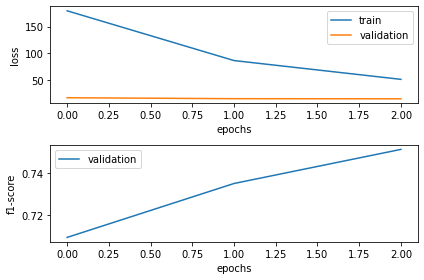

In [ ]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("f1-score")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

**Note :** we can do the same by computing the accuracy metric instead of F1-score using the function below ( so that we can do a comparison with all the previous methods ). For the record, f1-score was chosen for this task because since the beginning we've been performing a Named Entity Recognition task on our dataset and f1-measure is frequently used in such tasks.

In [ ]:
#permet d'évaluer les performances du model, seqeval pouvant évaluer celle d'un modèle de NER
metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Ignore les pairs ou sont set les labels à -100 (inutile pour le calcule des perfs)
    true_predictions = [
        [tag_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tag_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {

        "accuracy": results["overall_accuracy"],
    }
